In [ ]:
!pip install transformers
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import tensorflow 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm.auto import tqdm
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pre_post_question_preparing.csv')

In [ ]:
data.head()

,question,label
0,Are boots cold reliable?,0
1,is the main body rubber or plastic?,0
2,How long after placing order until US delivery?,0
3,Will this fit a Stern Monopoly machine?,0
4,Is the power cord detachable?,0


In [ ]:
# data = data.sample(n=50, replace=False)

In [ ]:
sentences = ["[CLS] " + sent + " [SEP]" for sent in data['question'].to_numpy()]
labels = data['label'].to_numpy()
sentences[3]

'[CLS] Will this fit a Stern Monopoly machine? [SEP]'

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(sentences, labels, random_state=42, test_size=0.2, stratify=labels, shuffle=True)

In [ ]:
np.bincount(test_label)

array([20000, 19535])

In [ ]:
np.bincount(train_label)

array([80000, 78139])

# Tokinizer&DataLaoder

In [ ]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenized_text = [tokenizer.tokenize(sent) for sent in train_data]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
print(tokenized_text[0])

['[CLS]', '"', 'does', 'this', 'fit', 'a', '5', '.', '5', '"', '"', 'bb', '##l', 'single', 'six', '?', '"', '[SEP]']


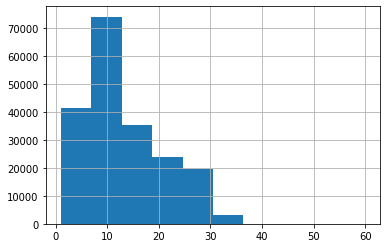

In [ ]:
data['question'].map(lambda x: len(x.split())).hist()

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype='long',
    truncating = 'post',
    padding ='post'
)
attention_mask = [[float(i>0) for i in sent]for sent in input_ids]

In [ ]:
input_ids

array([[ 101, 1000, 2515, ...,    0,    0,    0],
       [ 101, 9630, 8875, ...,    0,    0,    0],
       [ 101, 1045, 2031, ...,    0,    0,    0],
       ...,
       [ 101, 2003, 2023, ...,    0,    0,    0],
       [ 101, 2064, 1037, ...,    0,    0,    0],
       [ 101, 1045, 2453, ...,    0,    0,    0]])

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_label, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids, random_state=42, test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


In [ ]:
tokenized_test_text = [tokenizer.tokenize(sent) for sent in test_data]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_text]
input_ids_test = pad_sequences(
    input_ids_test,
    maxlen=100,
    dtype='long',
    truncating = 'post',
    padding ='post'
)
attention_mask_test = [[float(i>0) for i in sent]for sent in input_ids_test]


In [ ]:
test_inputs = torch.tensor(input_ids_test)
test_labels = torch.tensor(test_label)
test_masks = torch.tensor(attention_mask_test)

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

In [ ]:
test_labels

tensor([1, 1, 1,  ..., 0, 1, 0])

In [ ]:
train_dataloader = DataLoader(train_data, sampler = RandomSampler(train_data), batch_size=16)
validation_dataloader = DataLoader(validation_data, sampler = RandomSampler(validation_data), batch_size=16)
test_dataloader = DataLoader(test_data, sampler = RandomSampler(validation_data), batch_size= 16)

# Traning

In [ ]:
device  =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.3.ffn.lin1.bias', 'vocab_transform.bias', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'dis

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(model, optimizer, train_dataloader, val_dataloader, n_epoch):
  best_f1 = 0
  train_loss = []
  for i in tqdm(range(n_epoch)):
    for i, batch in tqdm(enumerate(train_dataloader)):
      model.train()
      batch = tuple(x.to(device) for x in batch)
      b_inputs_ids, b_input_mask, b_labels = batch

      optimizer.zero_grad()
      loss = model(b_inputs_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      train_loss.append(loss[0].item())
      loss[0].backward()
      optimizer.step()

      if i % 100 == 0 and i != 0:
        with torch.no_grad():
          model.eval()
          predicted_label = []
          real_label = []

          for batch in validation_dataloader:
            # добавляем батч для вычисления на GPU
            batch = tuple(t.to(device) for t in batch)
            
            # Распаковываем данные из dataloader
            b_input_ids, b_input_mask, b_labels = batch
            
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для валидационных данных.
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # Перемещаем logits и метки классов на CPU для дальнейшей работы
            logits = logits[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            batch_preds = np.argmax(logits, axis=1)
            batch_labels = label_ids
            predicted_label.extend(batch_preds)
            real_label.extend(batch_labels)

          f1 = f1_score(predicted_label, real_label, average='macro')
          print(f1)
          if f1 > best_f1:
            best_f1 = f1
            model.save_pretrained(f'/content/drive/MyDrive/Colab Notebooks/model_transformer_f1_{np.round(f1,5)}.pt')
          
    


In [ ]:
train(model, optimizer, train_dataloader, validation_dataloader, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.3317839939153216
0.3317839939153216
0.3317839939153216


KeyboardInterrupt: ignored